In [2]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

file_names = {
    "primary_cohort": "data/s41598-020-73558-3_sepsis_survival_primary_cohort.csv",
    "study_cohort": "data/s41598-020-73558-3_sepsis_survival_study_cohort.csv",
    "validation_cohort": "data/s41598-020-73558-3_sepsis_survival_validation_cohort.csv",
}

dict_df = dict()
for key, file in file_names.items():
    dict_df[key] = pd.read_csv(file)

### **Dataset information**

#### **What do the instances in this dataset represent?**

For the primary cohort, they represent records of patients affected by sepsis potential preconditions (ante Sepsis-3 definition); for the study cohort, they represent only the patients’ admissions defined by the novel Sepsis-3 definition.

#### **Are there recommended data splits?**

No recommendation, standard train-test split could be used. Can use three-way holdout split (i.e., training, validation/development, testing) when doing model selection.

#### **Does the dataset contain data that might be considered sensitive in any way?**

Yes. It contains information about the gender and age of the patient.

#### **Was there any data preprocessing performed?**

All the categorical variables have been encoded (so no preprocessing is necessary).

#### **Additional Information**

Primary cohort from Norway:
- 4 features for 110,204 patient admissions
- file: 's41598-020-73558-3_sepsis_survival_primary_cohort.csv'

Study cohort (a subset of the primary cohort) from Norway:
- 4 features for 19,051 patient admissions
- file: 's41598-020-73558-3_sepsis_survival_study_cohort.csv'

Validation cohort from South Korea:
- 4 features for 137 patients
- file: 's41598-020-73558-3_sepsis_survival_validation_cohort.csv'

The validation cohort from South Korea was used by Chicco and Jurman (2020) as an external validation cohort to confirm the generalizability of their proposed approach. 

#### **Has Missing Values?**

No

# I. Description des datasets
### I. 1) Nombre d'échantillons et de personnes décédées (target)

In [3]:
cohorts = ["primary_cohort", "study_cohort", "validation_cohort"]
sizes = [len(dict_df[cohort]) for cohort in cohorts]

fig = make_subplots(rows=2, cols=1, subplot_titles=[
    "Nombre d'échantillons", "Pourcentage de morts"
])

fig.add_trace(
    go.Bar(x=cohorts, y=sizes, text=sizes, textposition="auto", name="Taille"),
    row=1, col=1
)

prop_deads = [
    100 * (len(dict_df[cohort]) - dict_df[cohort].hospital_outcome_1alive_0dead.sum()) / len(dict_df[cohort])
    for cohort in cohorts
]

fig.add_trace(
    go.Bar(x=cohorts, y=prop_deads, text=[f"{v:.1f}%" for v in prop_deads],
           textposition="auto", name="% morts"),
    row=2, col=1
)

fig.update_layout(
    title="Nombre de patients et de morts",
    height=700,
    showlegend=False
)

fig.show()

On remarque bien que le dataset `study_cohort` est une sous partie de `primary_cohort`, représentant environ un cinquième des observations. \
D'ailleurs, dans ce dataset, le nombre de morts est bien plus important que dans `primary_cohort`. \
Le dataset de validation `validation_cohort`(provenant de données en Corée du Sud), est de taille biens moindre mais présente une proportion de patients n'ayant pas survécus similaires au dataset d'étude `study_cohort`.


### I. 2) Répartition des ages

In [4]:
fig = make_subplots(rows=1, cols=3, subplot_titles=cohorts)

for i, cohort in enumerate(cohorts):
    fig.add_trace(
        go.Histogram(x=dict_df[cohort].age_years, name=cohort, opacity=0.6),
        row=1, col=i+1
    )


fig.update_layout(
    title="Etude des âges",
    showlegend=False,
    height=400,
    width=900
)

fig.show()

fig = go.Figure()
for cohort in cohorts:
    fig.add_trace(
        go.Box(x=dict_df[cohort].age_years, name=cohort, opacity=0.6),

    )


fig.update_layout(barmode='group')  
fig.show()

`study_cohort` compte bien moins de patients jeunes (age < 40 ans) que les deux autres datasets. Cela a pour effet de décaler les moyenne et médianes d'age de `study_cohort` vers la droite.\
Mis à part cela, les répartitions d'age sont similaires, avec une mode aux alentours de 82 ans pour les deux populations. \
Cependant, le dataset de validation provenant des données coréennes ne contient que très peu d'ages aussi élevés. On note le 3e quantile à 72 ans. 
Ces nuances entre dataset d'entraînement et de test pourra poser problème à l'établissement du modèle final. 


### I. 3) Répartition des sexes

In [5]:
fig = make_subplots(rows=1, cols=len(cohorts), subplot_titles=cohorts)

for i, cohort in enumerate(cohorts):
    fig.add_trace(
        go.Histogram(x=dict_df[cohort].sex_0male_1female, name=cohort, xbins=dict(start=-0.5, end=1.5, size=1), opacity=0.6),
        row=1, col=i+1
    )


fig.update_layout(
    title="Nombre d'hommes (0) vs nombre de femmes (1)",
    showlegend=False,
    height=400,
    width=900,
    bargap=0.3
)

fig.show()

On remarque plus d'hommes que de femmes dans chaque population étudiée \
Cependant, pour les données coréennes il y a seulement 47 pour 90 hommes : elles ne représentent qu'un tiers des patients étudiés ici. \
Pour le groupe primaire il y a 47% de femmes et pour le groupe d'étude il y en a 45%, c'est similaire. 




### I. 4) Répartition des nombre d'épisode de la maladie 

In [6]:
fig = make_subplots(rows=1, cols=len(cohorts), subplot_titles=cohorts)

for i, cohort in enumerate(cohorts):
    fig.add_trace(
        go.Histogram(x=dict_df[cohort].episode_number, name=cohort, opacity=0.6),
        row=1, col=i+1
    )


fig.update_layout(
    title="Répartition des nombre d'épisode de la maladie",
    showlegend=False,
    height=400,
    width=900,
    bargap=0.3
)

fig.show()

Sans surprise, on remarque des répartitions similaires concernant les nombres d'épisode de la maladie pour les deux datasets issus des données norvégiennes. \
Les données coréennes ne comportent pas de patients ayant eu plus de 2 fois cette maladie.

## II. Lien entre les différentes features
### II. 1) Lien entre l'âge et le sexe des différents groupes

In [7]:
fig = make_subplots(
    rows=1,
    cols=len(cohorts),
    subplot_titles=cohorts)

colors = {0:'blue', 1:'pink'}  

for i, cohort in enumerate(cohorts):
    fig.add_trace(
        go.Histogram(
            x=dict_df[cohort].loc[dict_df[cohort].sex_0male_1female == 0, 'age_years'],
            name='Homme',
            opacity=0.6,
            marker_color=colors[0],
            nbinsx=20
        ),
        row=1, col=i+1
    )

    fig.add_trace(
        go.Histogram(
            x=dict_df[cohort].loc[dict_df[cohort].sex_0male_1female == 1, 'age_years'],
            name='Femme',
            opacity=0.6,
            marker_color=colors[1],
            nbinsx=20
        ),
        row=1, col=i+1
    )

fig.update_layout(
    title="Répartition des âges par sexe selon la cohorte",
    xaxis_title="Âge",
    yaxis_title="Nombre de patients",
    barmode='overlay',   
    height=500,
    width=1200,
    showlegend=False
)

fig.show()


Comme montré précédemment il y a moins de jeunes dans `primary_cohort` que dans `study_cohort`. \ 
Ces deux populations comportent légèrement plus d'hommes entre 50 et 90 ans et légèrement plus de femmes agées de plus de 90 ans. \
Pour la population validation d'origine coréenne, on remarque beaucoup plus d'hommes en général.

### II. 2) Effets généraux de l'age et du sexe sur le % de morts

In [8]:
fig = make_subplots(
    rows=1,
    cols=len(cohorts),
    subplot_titles=list(cohorts),
    shared_yaxes=True  
)

for i, cohort in enumerate(cohorts, start=1):
    
    prob = dict_df[cohort].copy()
    prob["age_bin"] = pd.cut(prob.age_years, bins=range(0, 101, 10), right=False)

    prob = (
        prob
        .groupby(['age_bin', 'sex_0male_1female'])
        .hospital_outcome_1alive_0dead
        .mean()
        .reset_index()
    )
    prob['death_prob'] = 1 - prob.hospital_outcome_1alive_0dead 

    for sex in [0, 1]:
        subset = prob[prob['sex_0male_1female'] == sex]
        fig.add_trace(
            go.Scatter(
                x=subset['age_bin'].astype(str),
                y=subset['death_prob'],
                mode='lines+markers',
                name=f"{'Homme' if sex==0 else 'Femme'} ({cohort})",
                line=dict(color=colors[sex]),
                showlegend=(i == 1) 
            ),
            row=1, col=i
        )


fig.update_layout(
    title="Visualisation des effets de l'âge et du sexe sur le % de mort",
    height=500,
    width=1200,
    xaxis_title="Tranches d'âge (ans)",
    yaxis_title="% de mort",
    yaxis=dict(range=[0, 1]), 
    legend_title="Sexe",
    template="plotly_white",
    font=dict(size=13)
)

fig.show()




C:\Users\pupin\AppData\Local\Temp\ipykernel_11652\1305488874.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\pupin\AppData\Local\Temp\ipykernel_11652\1305488874.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\pupin\AppData\Local\Temp\ipykernel_11652\1305488874.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Il ne sert à rien d'observer `validation_cohort` car pour de nombreuses tranches d'age il n'y a que très peu de données de patient. Ainsi moyenner pour ces tranches d'âge ne donne pas une valeur consistante de pourcentage de morts. \
Les deux datasets issus des données norvégiennes ont une allure similaire mais pas tout à fait les mêmes valeurs

In [9]:
fig = go.Figure()

for i, cohort in enumerate(cohorts[:2], start=1):
    prob = dict_df[cohort].copy()
    prob["age_bin"] = pd.cut(prob.age_years, bins=range(0, 101, 10), right=False)

    prob = (
        prob
        .groupby(['age_bin', 'sex_0male_1female'])
        .hospital_outcome_1alive_0dead
        .mean()
        .reset_index()
    )
    prob['death_prob'] = 1 - prob.hospital_outcome_1alive_0dead 
    for sex in [0, 1]:
        subset = prob[prob['sex_0male_1female'] == sex]
        fig.add_trace(
            go.Scatter(
                x=subset['age_bin'].astype(str),
                y=subset['death_prob'],
                mode='lines+markers',
                name=f"{'Homme' if sex==0 else 'Femme'} ({cohort})",
                line=dict(color=colors[sex], dash='solid' if i == 1 else 'dash')  # 🔹 dash différent pour différencier cohortes
            )
        )

fig.update_layout(
    title="Comparaison des deux premières cohortes – Effet de l'âge et du sexe sur la proportion de morts",
    height=500,
    width=900,
    xaxis_title="Tranches d'âge (ans)",
    yaxis_title="Probabilité de mort",
    yaxis=dict(range=[0, 1]),
    legend_title="Sexe et cohorte",
    template="plotly_white",
    font=dict(size=13)
)



fig.show()


C:\Users\pupin\AppData\Local\Temp\ipykernel_11652\3446930734.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\pupin\AppData\Local\Temp\ipykernel_11652\3446930734.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



On remarque bien qu'il y a davantage de morts dans le datasets d'études que dans le dataset d'origine, er ceci pour chaque âge. \
On ne sait pas précisément comment les données ont été sélectionnées pour créer le dataset d'étude mais il semble que les patients les plus vulnérables ait été choisis.

### II. 3) Effets du nombre d'épisodes de sepsis sur la mortalité

In [10]:
all_episodes = sorted(set().union(*[dict_df[c]['episode_number'].unique() for c in cohorts]))
color_map = {ep: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)] 
             for i, ep in enumerate(all_episodes)}

fig = go.Figure()

for cohort in cohorts:
    deaths = (
        dict_df[cohort]
        .query("hospital_outcome_1alive_0dead == 0")  # 0 = mort
        .groupby('episode_number')
        .size()
        .reset_index(name='death_count')
    )
    deaths['cohort'] = cohort  # pour garder l’info de cohorte

    for episode in sorted(deaths['episode_number'].unique()):
        subset = deaths[deaths['episode_number'] == episode]
        fig.add_trace(
            go.Bar(
                x=subset['cohort'],
                y=subset['death_count'],
                name=f"Épisode {episode}",
                marker_color=color_map[episode],  
                opacity=0.9
            )
        )

fig.update_layout(
    title="Répartition (%) des morts par cohorte et par épisode",
    barmode='relative',   
    barnorm='percent',   
    height=500,
    width=900,
    xaxis_title="Cohorte",
    yaxis_title="Pourcentage de morts (%)",
    showlegend=False,
    template="plotly_white",
    font=dict(size=13)
)

fig.show()


Les données de `primary_cohort` et de `study_cohort` contiennent des morts pour les mêmes nombre d'épisodes de la maladie.
Cependant, `validation_cohort` ne comprenant que des malades étant à leur premier ou second épisode de la maladie, on ne retrouve pas la même distribution. 

# III. Création d'un modèle de classification

### III. 1) Choix du modèle à entraîner
Pour ce type de dataset patient (données tabulaires avec features cliniques, biologiques, etc.), XGBoost est très pertinent :
- Gère bien les datasets avec features mixtes (numériques, catégoriques après encodage).
- Permet de contrôler le nombre de faux positifs / négatifs via les hyperparamètres
- Fournit des importances de variables, utile pour interprétation médicale.

**Remarque :** 
- Pas de feature engineering à faire
- On ne va pas utiliser `train_test_split` car le dataset d'entraînement a déjà été récupéré : c'est `study_cohort`
- Ici, on préfère déceler des faux positifs car il s'agit d'une première méthode statistique, qui doit ensuite mener à des tests cliniques afin de voir si le patient risque réellement de mourir. On évite particulièrement les faux négatifs.
####

### III. 2) Entraînement d'un premier modèle

La fonction `XGBClassifier` permet de traîter ce genre de problèmes avec `scale_pos_weight` afin de mettre plus de poids sur les personnes malades, dans le but de pondérer le mieux le modèle et de ne pas diagnostiquer tout le monde comme faux négatif \
On avait remarqué pourcentage de patients décédés dans `study_test` d'environ 20%.  \
On chosira alors `scale_pos_weight = 0.2`

In [11]:
import xgboost as xgb

In [12]:
from xgboost import XGBClassifier

X = dict_df["study_cohort"].drop("hospital_outcome_1alive_0dead", axis=1)
y = dict_df["study_cohort"]["hospital_outcome_1alive_0dead"]

ratio_neg_pos = 0.2  

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=5,
    learning_rate=0.1,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio_neg_pos,
    use_label_encoder=False
)

model.fit(X, y)



c:\Users\pupin\miniconda3\envs\myenv\lib\site-packages\xgboost\training.py:183: UserWarning:

[10:03:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Matrice de confusion :
[[10 14]
 [51 62]]


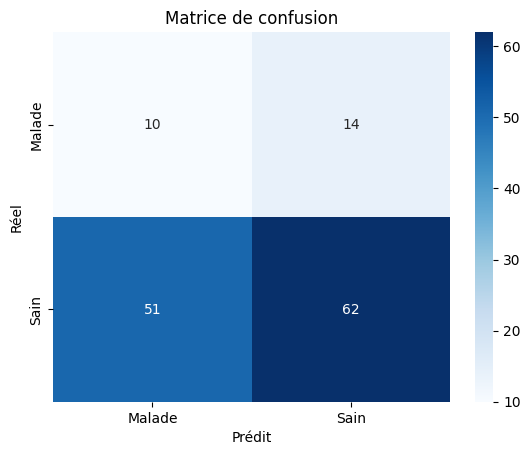

Recall (Sensibilité) : 0.549  # part de positifs détectés sur l'ensemble du dataset
Precision : 0.816  # proportion de vrais positifs parmi les prédits positifs
F1-score : 0.656  # compromis Precision/Recall


In [13]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Features et cible de la cohorte de validation
X_val = dict_df["validation_cohort"].drop("hospital_outcome_1alive_0dead", axis=1)
y_val = dict_df["validation_cohort"]["hospital_outcome_1alive_0dead"]

# Prédictions
y_pred = model.predict(X_val)

# Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
print("Matrice de confusion :")
print(cm)

# Affichage graphique
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Malade', 'Sain'], yticklabels=['Malade', 'Sain'])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# Calcul des métriques
recall = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Recall (Sensibilité) : {recall:.3f}  # part de positifs détectés sur l'ensemble du dataset")
print(f"Precision : {precision:.3f}  # proportion de vrais positifs parmi les prédits positifs")
print(f"F1-score : {f1:.3f}  # compromis Precision/Recall")

On remarque plusieurs problèmes : 52 faux négatifs, ici les malades ne sont pas détectés correctement.
12 faux positifs : cela n'est pas un très gros problème car ces personnes là pourront faire des examens supplémentaires afin de pouvoir vérifier si leur pronostic vital est en jeu.

### III. 3) Dimensionnement des hyperparamètres

In [14]:
X_train = dict_df["study_cohort"].drop("hospital_outcome_1alive_0dead", axis=1)
y_train = dict_df["study_cohort"]["hospital_outcome_1alive_0dead"]

X_val = dict_df["validation_cohort"].drop("hospital_outcome_1alive_0dead", axis=1)
y_val = dict_df["validation_cohort"]["hospital_outcome_1alive_0dead"]

# Liste des hyperparamètres à tester
max_depth_list = [3, 5, 7]
learning_rate_list = [0.01, 0.1, 0.2]
n_estimators_list = [100, 500, 1000]
scale_pos_weight_list = [0.1, 0.2, 0.5]  # exemple de ratios neg/pos

results = []

for max_depth in max_depth_list:
    for learning_rate in learning_rate_list:
        for n_estimators in n_estimators_list:
            for scale_pos_weight in scale_pos_weight_list:
                
                model = XGBClassifier(
                    objective='binary:logistic',
                    eval_metric='logloss',
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                    n_estimators=n_estimators,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    scale_pos_weight=scale_pos_weight,
                    use_label_encoder=False
                )
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                
                recall = recall_score(y_val, y_pred)
                precision = precision_score(y_val, y_pred)
                f1 = f1_score(y_val, y_pred)
                
                results.append({
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'n_estimators': n_estimators,
                    'scale_pos_weight': scale_pos_weight,
                    'recall': recall,
                    'precision': precision,
                    'f1': f1
                })

# Convertir en DataFrame pour analyse
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='f1', ascending=False))

c:\Users\pupin\miniconda3\envs\myenv\lib\site-packages\xgboost\training.py:183: UserWarning:

[10:03:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\pupin\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\pupin\miniconda3\envs\myenv\lib\site-packages\xgboost\training.py:183: UserWarning:

[10:03:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\pupin\miniconda3\envs\myenv\lib\site-packages\xgboost\training.py:183: UserWarning:

[10:03:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\pupin\miniconda3\envs\myenv\lib\site-packages\xgboost\tra

    max_depth  learning_rate  n_estimators  scale_pos_weight    recall  \
2           3           0.01           100               0.5  1.000000   
14          3           0.10           500               0.5  1.000000   
5           3           0.01           500               0.5  1.000000   
8           3           0.01          1000               0.5  1.000000   
11          3           0.10           100               0.5  1.000000   
..        ...            ...           ...               ...       ...   
9           3           0.10           100               0.1  0.194690   
3           3           0.01           500               0.1  0.176991   
0           3           0.01           100               0.1  0.000000   
27          5           0.01           100               0.1  0.000000   
54          7           0.01           100               0.1  0.000000   

    precision        f1  
2    0.824818  0.904000  
14   0.824818  0.904000  
5    0.824818  0.904000  
8    0.

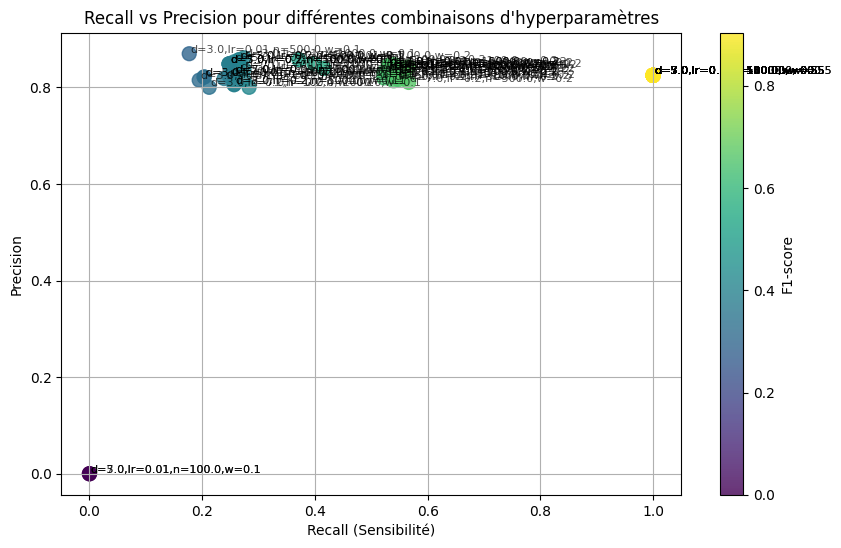

In [15]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    results_df['recall'], 
    results_df['precision'], 
    c=results_df['f1'],  # couleur selon le F1-score
    s=100,               # taille des points
    cmap='viridis',
    alpha=0.8
)

plt.colorbar(scatter, label='F1-score')
plt.xlabel('Recall (Sensibilité)')
plt.ylabel('Precision')
plt.title('Recall vs Precision pour différentes combinaisons d\'hyperparamètres')
plt.grid(True)

# Ajouter labels pour les points (optionnel, si pas trop de combinaisons)
for i, row in results_df.iterrows():
    plt.text(row['recall']+0.002, row['precision']+0.002,
             f"d={row['max_depth']},lr={row['learning_rate']},n={row['n_estimators']},w={row['scale_pos_weight']}",
             fontsize=8, alpha=0.7)

plt.show()

Pour les cas ou la précision est à 0.82 et le recall à 1.0, le modèle est très mauvais car il ne prédit que des patients vivants. On a donc une précision de 0.82 qui correspond à la proportion de vivants dans le dataset, et un recall de 1.0 car le modèle à bien prédit tous les vivants, mais il n'a prédit aucun mort : ce modèle est inutilisable en médecine.  
On va donc chercher les hyperparamètres pour lesquels le score f1 est le meilleur (compromis entre recall et précision) pour les cas où le recall est différent de 1, et voir ce que donne le modèle avec ces paramètres.

In [16]:
# Filtrer les résultats où recall < 1
filtered_results = [r for r in results if r['recall'] < 1]

# Trouver celui avec le F1 le plus élevé
best_result = max(filtered_results, key=lambda r: r['f1'])

# Afficher le résultat optimal
print("Meilleur résultat (sans recall=1) :")
print(best_result)


Meilleur résultat (sans recall=1) :
{'max_depth': 7, 'learning_rate': 0.2, 'n_estimators': 100, 'scale_pos_weight': 0.2, 'recall': 0.5663716814159292, 'precision': 0.8421052631578947, 'f1': 0.6772486772486772}


In [17]:
X_train = dict_df["study_cohort"].drop("hospital_outcome_1alive_0dead", axis=1)
y_train = dict_df["study_cohort"]["hospital_outcome_1alive_0dead"]

ratio_neg_pos = 0.2  

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=best_result['max_depth'],
    learning_rate=best_result['learning_rate'],
    n_estimators=best_result['n_estimators'],
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=best_result['scale_pos_weight'],
    use_label_encoder=False
)

model.fit(X_train, y_train)

c:\Users\pupin\miniconda3\envs\myenv\lib\site-packages\xgboost\training.py:183: UserWarning:

[10:04:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Matrice de confusion :
[[12 12]
 [49 64]]


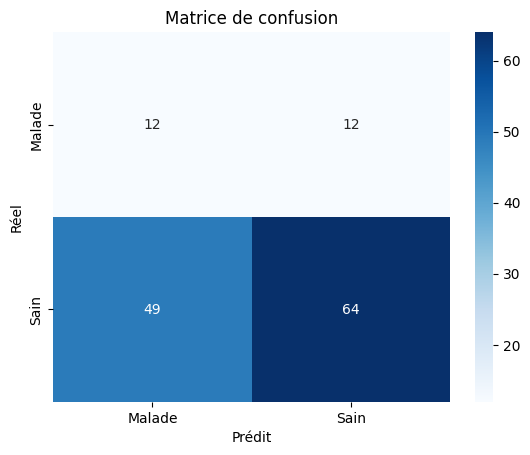

Recall (Sensibilité) : 0.566  # part de positifs détectés sur l'ensemble du dataset
Precision : 0.842  # proportion de vrais positifs parmi les prédits positifs
F1-score : 0.677  # compromis Precision/Recall


In [18]:
# Features et cible de la cohorte de validation
X_val = dict_df["validation_cohort"].drop("hospital_outcome_1alive_0dead", axis=1)
y_val = dict_df["validation_cohort"]["hospital_outcome_1alive_0dead"]

# Prédictions
y_pred = model.predict(X_val)

# Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
print("Matrice de confusion :")
print(cm)

# Affichage graphique
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Malade', 'Sain'], yticklabels=['Malade', 'Sain'])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# Calcul des métriques
recall = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Recall (Sensibilité) : {recall:.3f}  # part de positifs détectés sur l'ensemble du dataset")
print(f"Precision : {precision:.3f}  # proportion de vrais positifs parmi les prédits positifs")
print(f"F1-score : {f1:.3f}  # compromis Precision/Recall")

De toute évidence, le résultat n'est toujours pas satisfaisant : on prédit encore incorrectement la moitié des patients décédés, on ne peut pas se permettre de dire qu'un patient est hors de danger avec ce degré de précision.  
Nous allons donc essayer de trouver un meilleur classifieur.

### Test avec SVM

In [27]:
from sklearn import svm
 
C = [0.001, 0.01, 0.1, 1, 10, 100]
y_list = []
for c in C:
    svm_model = svm.SVC(kernel='rbf', C=c, gamma='scale', class_weight='balanced')
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_val)
    y_list.append(y_pred_svm)

Matrice de confusion :
[[21  3]
 [94 19]]
Pour gamma = 0.001 :


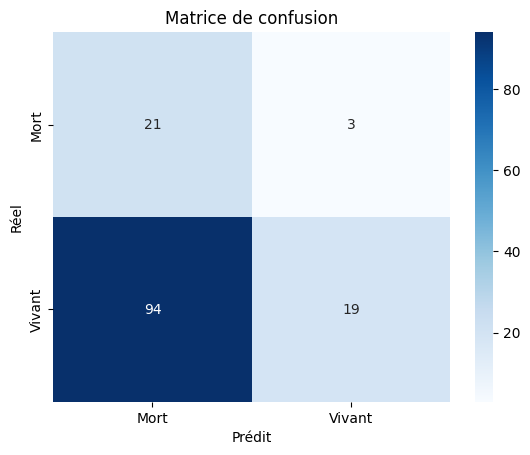

Recall (Sensibilité) : 0.168  # part de positifs détectés sur l'ensemble du dataset
Precision : 0.864  # proportion de vrais positifs parmi les prédits positifs
F1-score : 0.281  # compromis Precision/Recall
Matrice de confusion :
[[11 13]
 [38 75]]
Pour gamma = 0.01 :


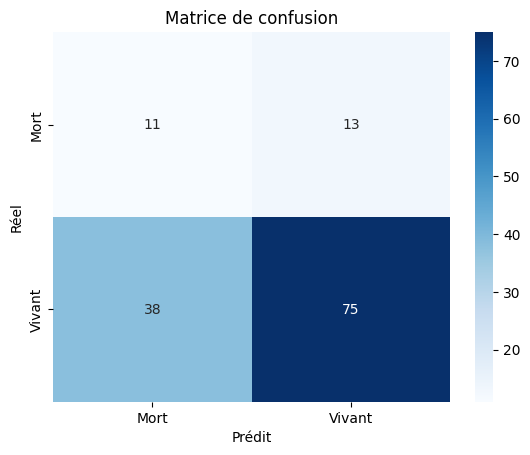

Recall (Sensibilité) : 0.664  # part de positifs détectés sur l'ensemble du dataset
Precision : 0.852  # proportion de vrais positifs parmi les prédits positifs
F1-score : 0.746  # compromis Precision/Recall
Matrice de confusion :
[[11 13]
 [38 75]]
Pour gamma = 0.1 :


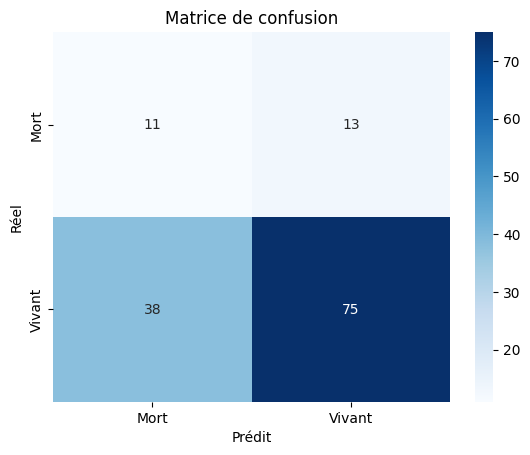

Recall (Sensibilité) : 0.664  # part de positifs détectés sur l'ensemble du dataset
Precision : 0.852  # proportion de vrais positifs parmi les prédits positifs
F1-score : 0.746  # compromis Precision/Recall
Matrice de confusion :
[[11 13]
 [32 81]]
Pour gamma = 1 :


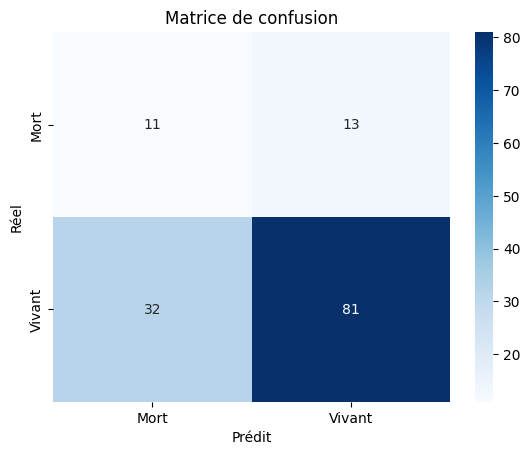

Recall (Sensibilité) : 0.717  # part de positifs détectés sur l'ensemble du dataset
Precision : 0.862  # proportion de vrais positifs parmi les prédits positifs
F1-score : 0.783  # compromis Precision/Recall
Matrice de confusion :
[[ 9 15]
 [29 84]]
Pour gamma = 10 :


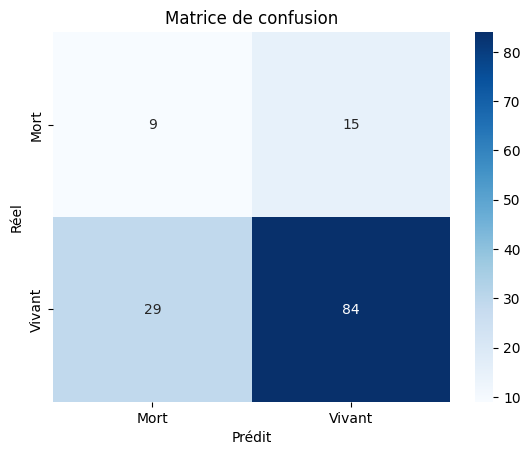

Recall (Sensibilité) : 0.743  # part de positifs détectés sur l'ensemble du dataset
Precision : 0.848  # proportion de vrais positifs parmi les prédits positifs
F1-score : 0.792  # compromis Precision/Recall
Matrice de confusion :
[[ 9 15]
 [29 84]]
Pour gamma = 100 :


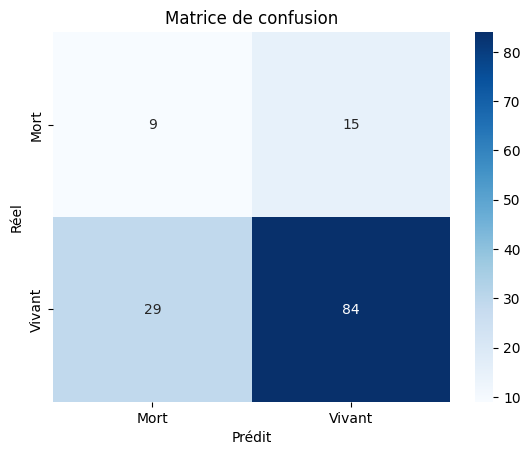

Recall (Sensibilité) : 0.743  # part de positifs détectés sur l'ensemble du dataset
Precision : 0.848  # proportion de vrais positifs parmi les prédits positifs
F1-score : 0.792  # compromis Precision/Recall


In [28]:
for k in range(len(C)):
    # Matrice de confusion
    cm = confusion_matrix(y_val, y_list[k])
    print("Matrice de confusion :")
    print(cm)
    print(f"Pour gamma = {C[k]} :")

    # Affichage graphique
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Mort', 'Vivant'], yticklabels=['Mort', 'Vivant'])
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.title("Matrice de confusion")
    plt.show()

    # Calcul des métriques
    recall = recall_score(y_val, y_list[k])
    precision = precision_score(y_val, y_list[k])
    f1 = f1_score(y_val, y_list[k])

    print(f"Recall (Sensibilité) : {recall:.3f}  # part de positifs détectés sur l'ensemble du dataset")
    print(f"Precision : {precision:.3f}  # proportion de vrais positifs parmi les prédits positifs")
    print(f"F1-score : {f1:.3f}  # compromis Precision/Recall")

Les résultats avec SVM ne sont toujours pas satisfaisants

### Test avec RandomForest

In [31]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
n_estimators = [50, 100, 200, 500, 1000]
max_depth = [3, 5, 7, 10]
max_features = ['sqrt', 'log2', 0.3, 0.5, 0.7]
min_samples_split = [2, 5, 10]
for n in n_estimators:
    for depth in max_depth:
        for max_feat in max_features:
            for min_split in min_samples_split:
                rf_model = RandomForestClassifier(n_estimators=n, max_depth=depth, max_features=max_feat, min_samples_split=min_split, class_weight='balanced', random_state=42)
                rf_model.fit(X_train, y_train)
                y_pred_rf = rf_model.predict(X_val)
                recall = recall_score(y_val, y_pred_rf)
                precision = precision_score(y_val, y_pred_rf)
                f1 = f1_score(y_val, y_pred_rf)
                print(f"n_estimators: {n}, max_depth: {depth}, max_features: {max_feat}, min_samples_split: {min_split} => Recall: {recall:.3f}, Precision: {precision:.3f}, F1-score: {f1:.3f}")
                # Matrice de confusion
                cm = confusion_matrix(y_val, y_pred_rf)
                print("Matrice de confusion :")
                print(cm)


n_estimators: 50, max_depth: 3, max_features: sqrt, min_samples_split: 2 => Recall: 0.575, Precision: 0.823, F1-score: 0.677
Matrice de confusion :
[[10 14]
 [48 65]]
n_estimators: 50, max_depth: 3, max_features: sqrt, min_samples_split: 5 => Recall: 0.575, Precision: 0.823, F1-score: 0.677
Matrice de confusion :
[[10 14]
 [48 65]]
n_estimators: 50, max_depth: 3, max_features: sqrt, min_samples_split: 10 => Recall: 0.575, Precision: 0.823, F1-score: 0.677
Matrice de confusion :
[[10 14]
 [48 65]]
n_estimators: 50, max_depth: 3, max_features: log2, min_samples_split: 2 => Recall: 0.575, Precision: 0.823, F1-score: 0.677
Matrice de confusion :
[[10 14]
 [48 65]]
n_estimators: 50, max_depth: 3, max_features: log2, min_samples_split: 5 => Recall: 0.575, Precision: 0.823, F1-score: 0.677
Matrice de confusion :
[[10 14]
 [48 65]]
n_estimators: 50, max_depth: 3, max_features: log2, min_samples_split: 10 => Recall: 0.575, Precision: 0.823, F1-score: 0.677
Matrice de confusion :
[[10 14]
 [48 6

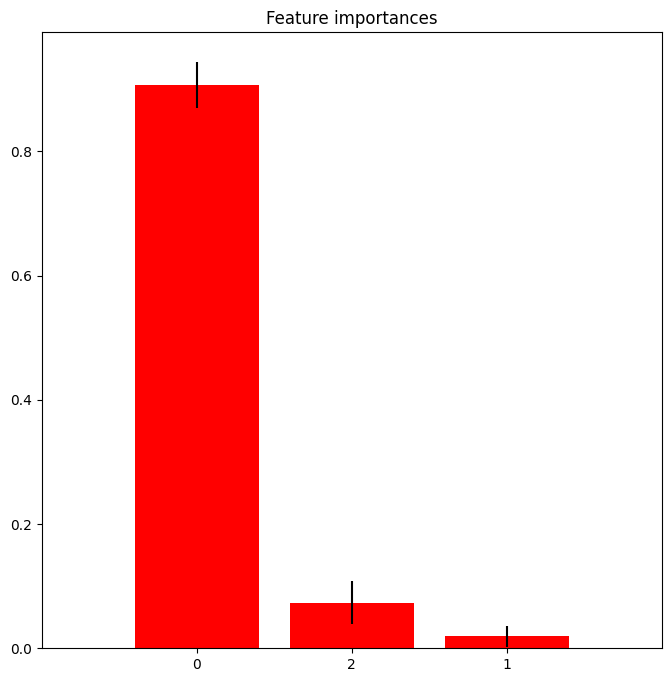

In [30]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# IV. Conclusion de l'étude : performance du modèle et limites